In [1]:
# !pip install --upgrade torch

    100% |████████████████████████████████| 752.0MB 61kB/s  eta 0:00:01    35% |███████████▎                    | 264.2MB 40.5MB/s eta 0:00:13██████▋        | 556.1MB 44.4MB/s eta 0:00:05  | 594.6MB 27.5MB/s eta 0:00:06  | 599.5MB 47.0MB/s eta 0:00:043��████████▏     | 616.1MB 39.3MB/s eta 0:00:0482% |██████████████████████████▎     | 618.4MB 50.3MB/s eta 0:00:03��███▍     | 620.8MB 40.8MB/s eta 0:00:04�█▌     | 623.0MB 51.6MB/s eta 0:00:03�████████████████████▋     | 625.4MB 49.4MB/s eta 0:00:03[K    83% |██████████████████████████▊     | 628.4MB 46.6MB/s eta 0:00:03��████████▉     | 631.0MB 41.1MB/s eta 0:00:03[K    84% |███████████████████████████     | 633.5MB 42.6MB/s eta 0:00:03��███████████████████▌    | 645.1MB 48.8MB/s eta 0:00:03��██████████▌    | 647.4MB 43.8MB/s eta 0:00:03��████████████████▋    | 650.0MB 50.0MB/s eta 0:00:03�████████████████▊    | 652.4MB 43.0MB/s eta 0:00:03��██████████████    | 657.2MB 42.0MB/s eta 0:00:03��██    | 659.7MB 52.0MB/s eta 0:00:02██████▏   |

In [ ]:
import gym
import random
import numpy as np
from collections import deque

import torch

from IPython import display
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from dqn_agent import Agent

In [1]:
import gym
import numpy as np
from collections import namedtuple, deque
from IPython import display
import matplotlib.pyplot as plt

from dueling_agent import *

In [2]:
env = gym.make('Enduro-v0')
print(env.observation_space)
print(env.action_space)

action_dim = env.action_space.n

Box(210, 160, 3)
Discrete(9)


# 1. Preprocess image

The observed frame of the game contained information not useful for the training (e.g. the points panel and the sky). So we need to cut off those redundant pixels. And we could turn the RGB images into grey to accelerate training.

Also, four consecutive frames are stacked together to capture the speed, direction  and other time-dependent info.

In [2]:
#img = plt.imshow(env.render(mode='rgb_array'))
#state = env.reset()
#env.seed(1234)
#sum_rewards = 0
#for _ in range(100):
#    action = env.action_space.sample() 
#    img.set_data(env.render(mode='rgb_array')) 
#    plt.axis('off')
#    plt.imshow(state)
#    display.display(plt.gcf())
#    display.clear_output(wait=True)
#    next_state, reward, done, _ = env.step(action)
#    sum_rewards += reward
#    if done:
#        break 
#    state = next_state

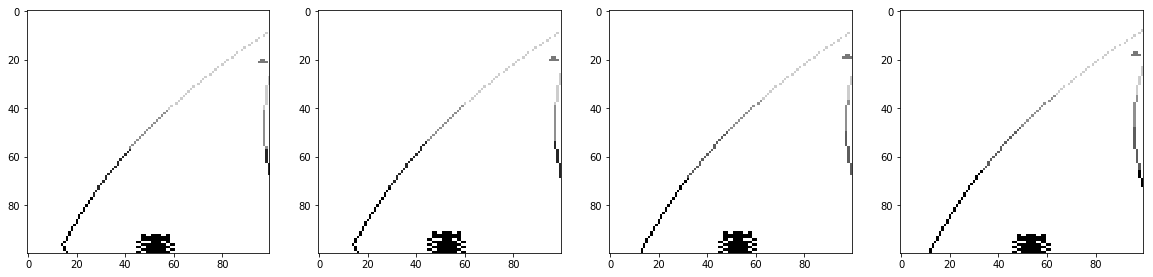

In [12]:
env.reset()
for _ in range(100):
    action = env.action_space.sample() 
    state, reward, done, _ = env.step(action)
    
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(141)
action = env.action_space.sample() 
state, reward, done, _ = env.step(action)
frame = preprocess_frames([state])
ax.imshow(frame[0], cmap='Greys')

ax = fig.add_subplot(142)
action = env.action_space.sample() 
state, reward, done, _ = env.step(action)
frame = preprocess_frames([state])
ax.imshow(frame[0], cmap='Greys')

ax = fig.add_subplot(143)
action = env.action_space.sample() 
state, reward, done, _ = env.step(action)
frame = preprocess_frames([state])
ax.imshow(frame[0], cmap='Greys')

ax = fig.add_subplot(144)
action = env.action_space.sample() 
state, reward, done, _ = env.step(action)
frame = preprocess_frames([state])
ax.imshow(frame[0], cmap='Greys')

plt.show()

# 2. Train agent

In [8]:
NUM_FRAMES = 4
agent = Agent(action_dim, NUM_FRAMES)

NUM_EPISODES = 100
eps_start = 1.
eps_end = 0.1
eps_decay = 0.95

score_list = []
best_score = 10.0

eps = eps_start

In [9]:
for e in range(1, NUM_EPISODES+1):
    print('\nEpisode {}...eps {:.4f}'.format(e, eps))
    # initialize 
    env.reset()
    sum_rewards = 0
    frame_list = deque(maxlen = NUM_FRAMES)
    for _ in range(NUM_FRAMES):
        action = env.action_space.sample()
        frame, reward, done, _ = env.step(action)
        sum_rewards += reward
        frame_list.append(frame)
        
    state = preprocess_frames(frame_list)
    while True:
        action = agent.act(state, eps)
        reward, next_state, done = collect_tuple(env, action, k = NUM_FRAMES)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        sum_rewards += reward
        
        print('\rsum of rewards {}...loss {:.6f}...step {}'.format(sum_rewards, agent.loss, agent.t_step), end="")
        if done:
            break
            
    score_list.append(sum_rewards)
    
    if sum_rewards >= best_score:
        torch.save(agent.online_net.state_dict(), 'gpu_checkpoint2.pth')
        best_score = sum_rewards
        print('\nckeckpoint saved!')
        
    eps = max(eps_end, eps_decay * eps)
  


Episode 1...eps 1.0000
sum of rewards 0.0...loss 0.000097...step 1051
Episode 2...eps 0.9500
sum of rewards 0.0...loss 0.000064...step 2158
Episode 3...eps 0.9025
sum of rewards 0.0...loss 0.000058...step 3271
Episode 4...eps 0.8574
sum of rewards 0.0...loss 0.000042...step 4384
Episode 5...eps 0.8145
sum of rewards 0.0...loss 0.000058...step 5492
Episode 6...eps 0.7738
sum of rewards 0.0...loss 0.009352...step 6605
Episode 7...eps 0.7351
sum of rewards 0.0...loss 0.000087...step 7713
Episode 8...eps 0.6983
sum of rewards 0.0...loss 0.000035...step 8818
Episode 9...eps 0.6634
sum of rewards 0.0...loss 0.001105...step 9927
Episode 10...eps 0.6302
sum of rewards 3.0...loss 0.000080...step 11036
Episode 11...eps 0.5987
sum of rewards 0.0...loss 0.000607...step 12137
Episode 12...eps 0.5688
sum of rewards 0.0...loss 0.015874...step 13244
Episode 13...eps 0.5404
sum of rewards 0.0...loss 0.018823...step 14349
Episode 14...eps 0.5133
sum of rewards 0.0...loss 0.002466...step 154600
Episode 

KeyboardInterrupt: 

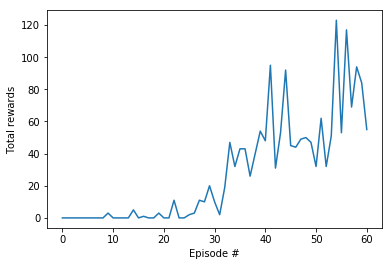

In [10]:
fig = plt.figure()
plt.plot(np.arange(len(score_list)), score_list)
plt.ylabel('Total rewards')
plt.xlabel('Episode #')
plt.savefig('plot_of_rewards.png')
plt.show()

# 3. Watch a trained agent

In [11]:
# load checkpoint parameters
agent.online_net.load_state_dict(torch.load('gpu_checkpoint2.pth'))
agent.online_net.eval()

NUM_FRAMES = 4
NUM_EPISODES = 3
for e in range(1, NUM_EPISODES+1):
    # initialize 
    env.reset()
    sum_rewards = 0
    frame_list = deque(maxlen = NUM_FRAMES)
    for _ in range(NUM_FRAMES):
        action = env.action_space.sample()
        frame, reward, done, _ = env.step(action)
        sum_rewards += reward
        frame_list.append(frame)
        
    state = preprocess_frames(frame_list)
    while True:
        action = agent.act(state, eps)
        reward, next_state, done = collect_tuple(env, action, k = NUM_FRAMES)
        state = next_state
        sum_rewards += reward
        print('\rEpisode {}...sum of rewards {}'.format(e, sum_rewards), end="")
        if done:
            break
        
    print('\rEpisode {}...sum of rewards {}'.format(e, sum_rewards))

Episode 1...sum of rewards 91.0
Episode 2...sum of rewards 55.0
Episode 3...sum of rewards 43.0


In [13]:
# save a cpu copy
torch.save(agent.online_net.cpu().state_dict(), 'cpu_checkpoint.pth')

In [ ]:
# close the environment
env.close()